In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rotate
import pickle
import sys
sys.path.insert(0,'/home/georgeos/Documents/GitHub/SYMPTOMM2')
import itertools
from joblib import Parallel, delayed
from skimage.morphology import opening
from PIL import Image       
import pymunk
from skimage.transform import PiecewiseAffineTransform, warp
from skimage import data
from copy import deepcopy
from SYMPTOMM.PSF import get_fluorescence_kernel
import cupy as cp
from cupyx.scipy.ndimage import convolve as cuconvolve
from skimage.exposure import rescale_intensity
from scipy.ndimage import convolve
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.special import jv, jve
from matplotlib_scalebar.scalebar import ScaleBar
from skimage.exposure import match_histograms
from numpy import fft
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from SYMPTOMM.image_manipulation.pySHINE import sfMatch, pol2cart, cart2pol, lumMatch
import tifffile
from skimage.util import random_noise
import skimage
from skimage.morphology import opening
import os
viridis = cm.get_cmap('viridis', 12)
newcolors = viridis(np.linspace(0, 1, 256))

YFP_cols = np.zeros((256,4))
for x in range(256):
    YFP_cols[x,0:2]=x/256
YFP_cols[:,-1]=1

CFP_cols = np.zeros((256,4))
for x in range(256):
    CFP_cols[x,1:3]=x/256
CFP_cols[:,-1]=1

RFP_cols = np.zeros((256,4))
for x in range(256):
    RFP_cols[x,0]=x/256
RFP_cols[:,-1]=1

GFP_cols = np.zeros((256,4))
for x in range(256):
    GFP_cols[x,1]=x/256
GFP_cols[:,-1]=1

BFP_cols = np.zeros((256,4))
for x in range(256):
    BFP_cols[x,2]=x/256
BFP_cols[:,-1]=1

YFP_cmap = ListedColormap(YFP_cols)
CFP_cmap = ListedColormap(CFP_cols)
RFP_cmap = ListedColormap(RFP_cols)
GFP_cmap = ListedColormap(GFP_cols)
BFP_cmap = ListedColormap(BFP_cols)
fluorescent_cmaps = [YFP_cmap,CFP_cmap,RFP_cmap,GFP_cmap,BFP_cmap]
em_wavelengths = [0.527,0.480,0.610,0.507,0.44]
RGBs = [[0,1],[1,2],[0],[1],[2]]
names = ["YFP","CFP","RFP","GFP","BFP"]

<ipython-input-2-943804d1f9d9>:29: RuntimeWarning: invalid value encountered in true_divide
  PSF = (2*jv(1,rr)/(rr))**2


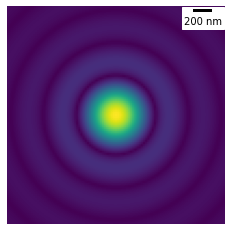

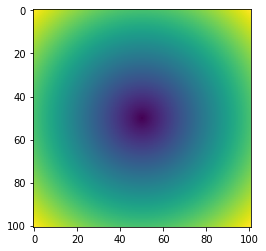

In [2]:
# Function to add camera noise
def add_camera_noise(input_irrad_photons, qe=0.69, sensitivity=5.88,
                     dark_noise=2.29, bitdepth=12, baseline=100,
                     rs=np.random.RandomState(seed=42)):
 
    # Add shot noise
    photons = rs.poisson(input_irrad_photons, size=input_irrad_photons.shape)
    
    # Convert to electrons
    electrons = qe * photons
    
    # Add dark noise
    electrons_out = rs.normal(scale=dark_noise, size=electrons.shape) + electrons
    
    # Convert to ADU and add baseline
    max_adu     = np.int(2**bitdepth - 1)
    adu         = (electrons_out * sensitivity).astype(np.int) # Convert to discrete numbers
    adu += baseline
    adu[adu > max_adu] = max_adu # models pixel saturation
    
    return adu

def get_fluorescence_kernel(Lambda,NA,n,radius,scale):
    r = np.arange(-radius,radius+1)
    kaw = 2* NA/n * np.pi/Lambda
    xx,yy = np.meshgrid(r,r)
    xx, yy = xx*scale, yy*scale
    rr = np.sqrt(xx**2+yy**2) * kaw 
    PSF = (2*jv(1,rr)/(rr))**2
    PSF[radius,radius] = 1
    return PSF, np.sqrt(xx**2+yy**2)

radius = 50
scale=0.11/5
Lambda = 0.63
NA = 0.95
PSF = get_fluorescence_kernel(Lambda,NA,1,radius,scale)
plt.imshow(np.sqrt(PSF[0]))
scalebar = ScaleBar(scale, 'um')
plt.axis("off")
plt.gca().add_artist(scalebar)
plt.show()
plt.imshow(PSF[1])

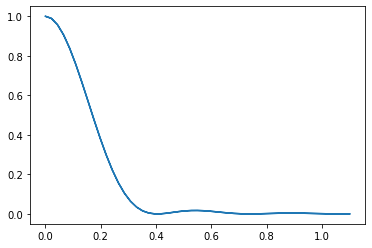

In [3]:
plt.plot(PSF[1][int(radius),:],PSF[0][int(radius),:])

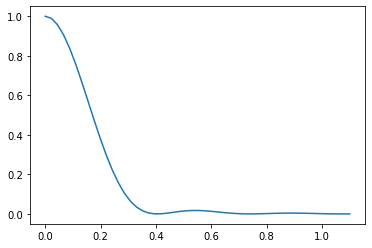

In [4]:
x_axis = np.arange(len(PSF[0][0,:])/2) * scale
y_axis = PSF[0][int(radius),int(radius):]
plt.plot(x_axis,y_axis)

(330, 40)

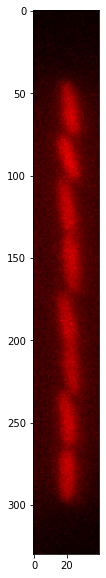

In [5]:
real_image = tifffile.imread("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches/trench_10/T_021.tif")
real_image[:]
plt.figure(figsize=(10,10))
plt.imshow(real_image,cmap=RFP_cmap)
real_image.shape

[303.03030303  40.        ]


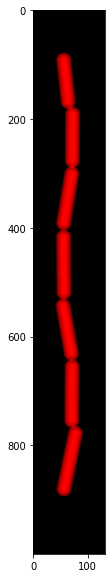

In [6]:
sample = np.array(Image.open("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/training_data/OPL_renders/OPL_intensity_900.tif"))
sample = sample[:,68:200]
sample = rescale_intensity(sample).astype(np.float64)
print(np.array(sample.shape)/3.3)
plt.figure(figsize=(10,10))
plt.imshow(sample,cmap=RFP_cmap)
plt.show()

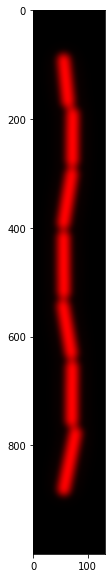

In [7]:
convolved = cp.asnumpy(cuconvolve(cp.array(sample),cp.array(PSF[0])))
background_signal = 500/6414 * convolved.max()
convolved  += background_signal
plt.figure(figsize=(10,10))
plt.imshow(convolved,cmap=RFP_cmap)
plt.show()

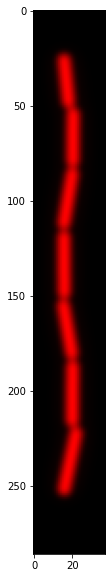

(286, 38)

In [8]:
image_rescaled = rescale(convolved, 1/3.5, anti_aliasing=False)
image_rescaled = (rescale_intensity(image_rescaled).astype(np.float64)*255)
plt.figure(figsize=(10,10))
plt.imshow(image_rescaled,cmap=RFP_cmap)
plt.show()
image_rescaled.shape

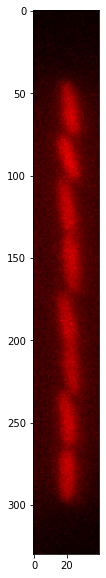

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(real_image,cmap=RFP_cmap)

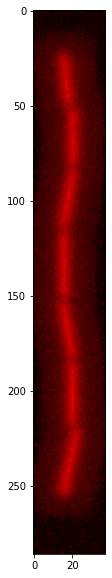

In [45]:
matched = match_histograms(image_rescaled, real_image, multichannel=False)

#noisy_img  = add_camera_noise(rescale_intensity(matched)*100,qe=0.8, sensitivity=92.88,
           #          dark_noise=0.29, bitdepth=16, baseline=100)

noisy_img = random_noise(rescale_intensity(matched), mode="poisson")
noisy_img = random_noise(rescale_intensity(matched), mode="gaussian", mean=0,var=0.002,clip=False)
noisy_img_matched = match_histograms(noisy_img, real_image, multichannel=False)

plt.figure(figsize=(10,10))
plt.imshow((noisy_img_matched),cmap=RFP_cmap)

In [46]:
real_stack = tifffile.imread("/home/georgeos/Documents/GitHub/SYMPTOMM2/prototyping/real_image_for_hist_match_stack.tif")

In [47]:
training_data_dir = "/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/training_data/OPL_renders/"

In [48]:
files = os.listdir(training_data_dir)
files.sort()

In [15]:
samples = files[:int(len(files)/2)]
masks = files[int(len(files)/2):]

In [16]:
_ = np.random.randint(0, len(files)/2-1)
print(masks[_])
print(samples[_])

OPL_mask_397.tif
OPL_intensity_397.tif


In [17]:
training_data_dir+samples[0]

'/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/training_data/OPL_renders/OPL_intensity_000.tif'

In [24]:
## main loop

for x in range(int(len(files)/2)):
    sample = np.array(Image.open(training_data_dir+samples[x]))
    sample = sample[:,68:200]
    sample = rescale_intensity(sample).astype(np.float64)
    convolved = cp.asnumpy(cuconvolve(cp.array(sample),cp.array(PSF[0])))
    background_signal = 500/6414 * convolved.max()
    convolved  += background_signal
    image_rescaled = rescale(convolved, 1/4.5, anti_aliasing=False)
    image_rescaled = (rescale_intensity(image_rescaled).astype(np.float64)*255)
    
    matched = match_histograms(image_rescaled, real_image, multichannel=False)
    noisy_img = random_noise(rescale_intensity(matched), mode="gaussian", mean=5,var=0.0005,clip=False)

    noisy_img_matched = match_histograms(noisy_img, real_image, multichannel=False)
    im = Image.fromarray(skimage.img_as_uint(rescale_intensity(noisy_img_matched)))
    im.save("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/training_data/convolutions/synth_{}.tif".format(str(x).zfill(3)))

In [25]:
for x in range(int(len(files)/2)):
    sample = np.array(Image.open(training_data_dir+masks[x]))
    sample = sample[:,68:200]
    sample = opening(sample,np.ones((5,15)))
    sample = sample.astype(np.bool_)
    image_rescaled = rescale(sample, 1/4.5, anti_aliasing=False, preserve_range=True, clip=True,mode="constant")
    im = Image.fromarray(image_rescaled)
    im.save("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/training_data/masks/synth_{}.tif".format(str(x).zfill(3)))

In [ ]:
type(sample)